# Implementation of 2DCellPol

## Create Dataset

In [17]:
from utils.create_dataset_train import *

#define the directories with the images and gt, and the directories 
#where the images and outputs to train the model should be saved
split_ = 'val' #train or val
save_imgs_dir = r'/home/jovyan/discotreino/2DCellPol_Github/Dataset/' + split_ + '/images' #directory where the image patches for training will be saved
save_outputs_dir = r'/home/jovyan/discotreino/2DCellPol_Github/Dataset/' + split_ + '/outputs' #directory where the output patches for training will be saved
images_dir = r'/home/jovyan/discotreino/2DCellPol_Github/images' # directory containing the original .tif images
                                                                          # image shape = (x,y,channels)
gt_dir = r'/home/jovyan/discotreino/2DCellPol_Github/annotations' #directory with the gt nucleus-Golgi vectors (.csv files)
size_ = 256 #size of the sub-volumes
step_ = 128 #overlap between sub-volumes

n_radius = 26 #nucleus radius for the Gaussians in the Gaussian heatmap (in voxels)
g_radius = 18 #Golgi radius for the Gaussians in the Gaussian heatmap (in voxels)

cellpol_data_creation(gt_dir, images_dir, n_radius, g_radius, size_, step_, save_imgs_dir, save_outputs_dir)

Directory /home/jovyan/discotreino/2DCellPol_Github/Dataset/val/images created.
Directory /home/jovyan/discotreino/2DCellPol_Github/Dataset/val/outputs created.
Directory /home/jovyan/discotreino/2DCellPol_Github/Dataset/val/vectors created.


## Visualize the Dataset

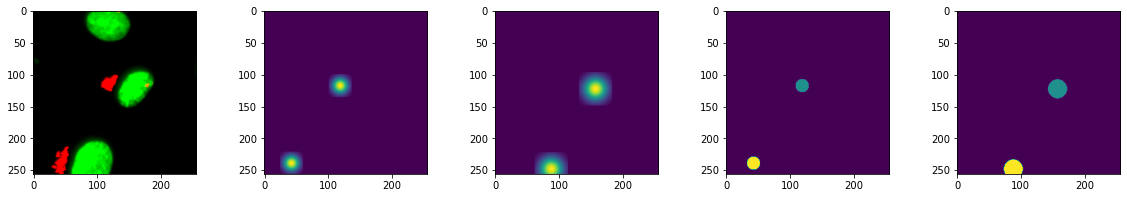

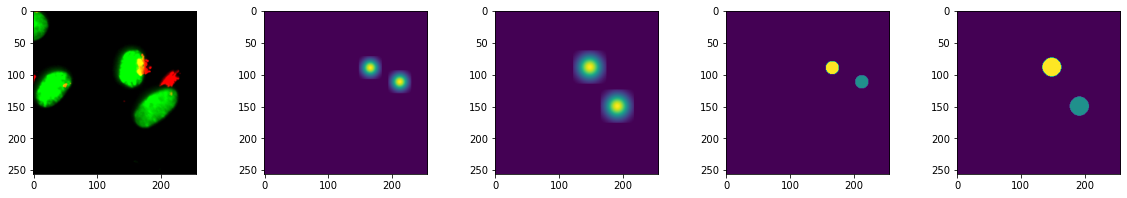

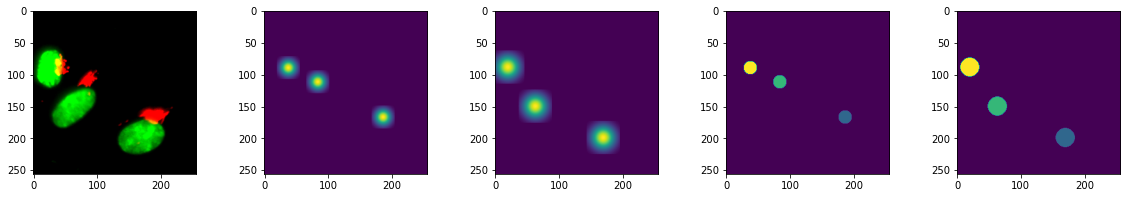

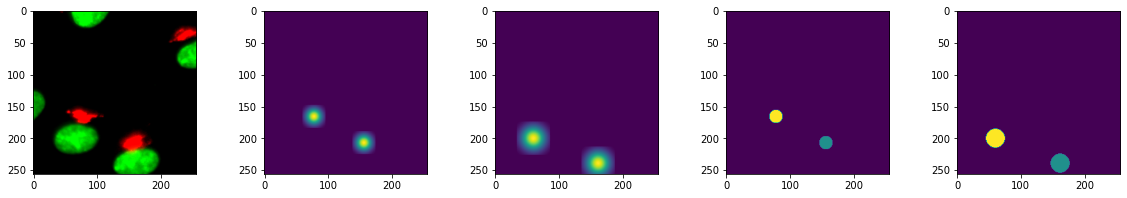

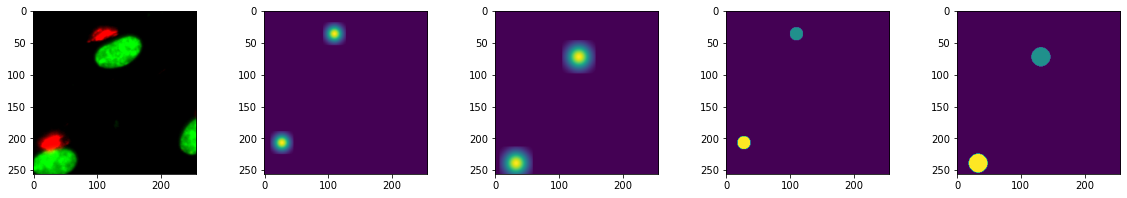

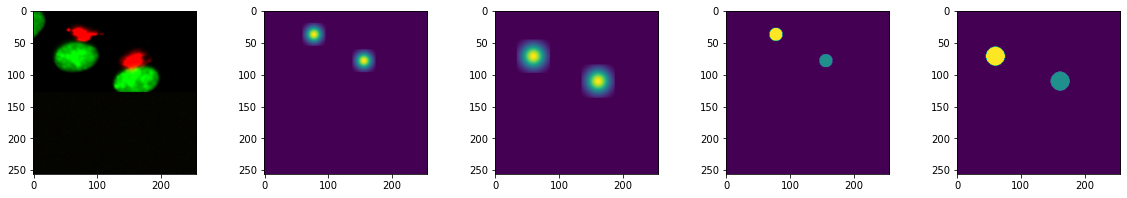

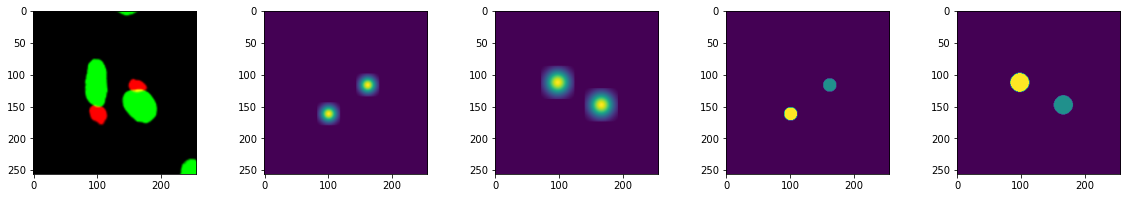

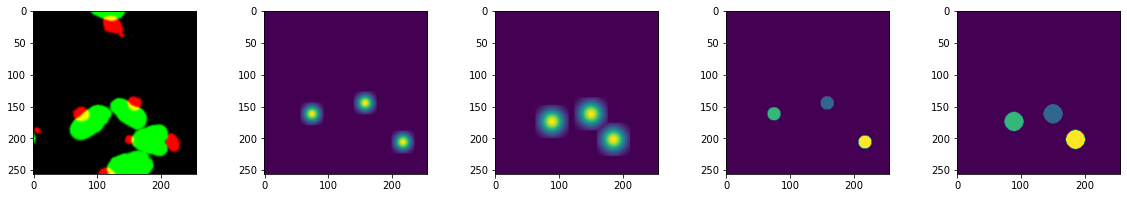

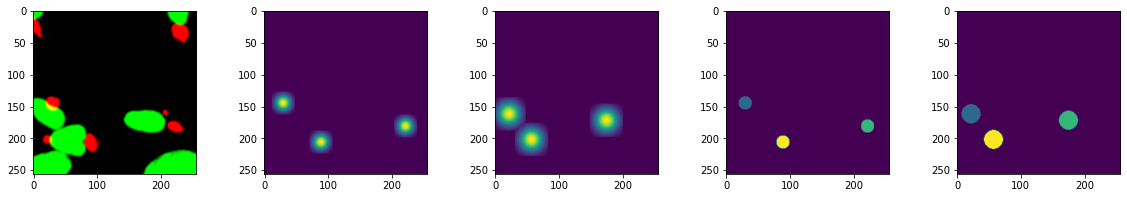

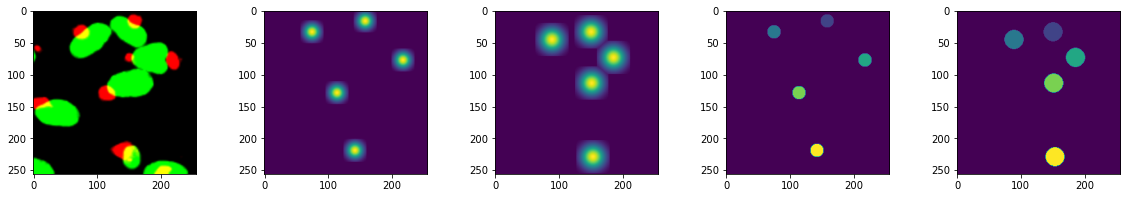

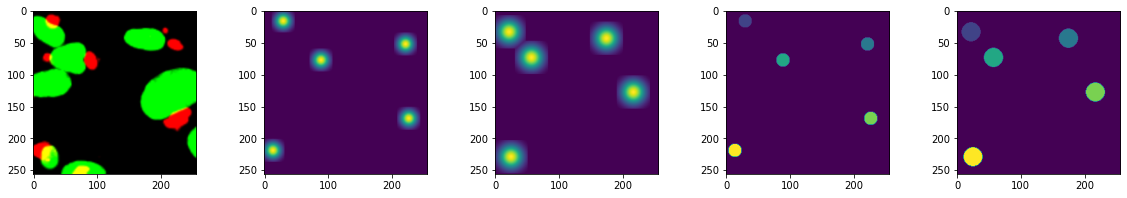

In [2]:
import matplotlib.pyplot as plt
k = 50
for img, gt in zip(os.listdir(save_imgs_dir), os.listdir(save_outputs_dir)):
    image = np.load(os.path.join(save_imgs_dir, str(k)+'.npy'))
    gt = np.load(os.path.join(save_outputs_dir, str(k)+'.npy'))
    
    image_aux = np.zeros((size_,size_,3)).astype('uint8')
    image_aux[:,:,0:2] = image
    
    plt.rcParams["figure.figsize"] = (20,3)
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5)
    ax1.imshow(image_aux)
    ax2.imshow(gt[:,:,0])
    ax3.imshow(gt[:,:,1])
    ax4.imshow(gt[:,:,2])
    ax5.imshow(gt[:,:,3])
    k+=1
    if k>60:
        break

# Train the Model

In [3]:
import os
from utils.threeDCellPol_utils import *

_size = 256 #patch size in the x- and y-directions

data_dir = '/home/jovyan/discotreino/2DCellPol_Github/Dataset/' #directory with the folders "train/images"
                                 #"train/outputs", "val/images", "val/outputs"
save_dir = '/home/jovyan/discotreino/2DCellPol_Github/model/' #directory to save
                                                         #the models and the log file

# Parameters
data_train_configs = {'dim': (_size,_size,2),
                                        'mask_dim':(_size,_size,4),
                                        'batch_size': 4,
                                        'shuffle': True}

data_val_test_configs = {'dim': (_size,_size,2),
                                                'mask_dim':(_size,_size,4),
                                                'batch_size': 4,
                                                'shuffle': True}

training_configs = {'initial_learning_rate':0.001,
                'learning_rate_drop':0.8,
                'learning_rate_patience':50,
                'learning_rate_epochs':None, 
                'early_stopping_patience':50,
                'n_epochs':50}

# Generators
train_generator = DataGenerator(data_dir, partition='train', configs=data_train_configs, data_aug=True) 
validation_generator = DataGenerator(data_dir, partition='val', configs=data_train_configs, data_aug=False)

model = threeDCellPol() #training from scratch

model.summary()

model = train_model(model=model, model_file=os.path.join(save_dir, 'best_3dcellpol.hdf5'), 
                        logging_file= os.path.join(save_dir, "logs_3dcellpol.log"),
						training_generator=train_generator,
                        validation_generator=validation_generator,
                        steps_per_epoch=train_generator.__len__(),
                        validation_steps=validation_generator.__len__(), **training_configs)

model.save(os.path.join(save_dir,'final_3dcellpol.hdf5'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
673/673 [==============================] - 585s 453ms/step - loss: 1.6803 - weighted_mean_se: 0.4852 - pull_loss_vis: 0.2341 - push_loss_vis: 0.9609 - val_loss: 1.5558 - val_weighted_mean_se: 0.4503 - val_pull_loss_vis: 0.2718 - val_push_loss_vis: 0.8337
Epoch 2/50
673/673 [==============================] - 270s 401ms/step - loss: 0.8729 - weighted_mean_se: 0.4008 - pull_loss_vis: 0.1695 - push_loss_vis: 0.3027 - val_loss: 1.1942 - val_weighted_mean_se: 0.3837 - val_pull_loss_vis: 0.1316 - val_push_loss_vis: 0.6790
Epoch 3/50
673/673 [==============================] - 355s 527ms/step - loss: 0.7639 - weighted_mean_se: 0.3757 - pull_loss_vis: 0.1422 - push_loss_vis: 0.2460 - val_loss: 1.2241 - val_weighted_mean_se: 0.3855 - val_pull_loss_vis: 0.2443 - val_push_loss_vis: 0.5943
Epoch 4/50
673/673 [==============================] - 355s 528ms/step - loss: 0.7143 - weighted_mean_se: 0.3645 - pull_loss_vis: 0.1287 - push_loss_vis: 0.2211 - val_loss: 0.8699 - val_weighted_mean_se:

## Threshold Optimization

#### Prediction Validation

In [1]:
from optimization.test_utils_optimization import *

pred_dir = r'/home/jovyan/discotreino/2DCellPol_Github/results_val' #directory where the validation results will be saved
gt_dir = r'/home/jovyan/discotreino/2DCellPol_Github/Dataset/val/vectors' #directory with the ground truth validation vectors
img_dir = r'/home/jovyan/discotreino/2DCellPol_Github/Dataset/val/images' # directory containing the validation sub-volumes
model_path = r'/home/jovyan/discotreino/2DCellPol_Github/model/final_3dcellpol.hdf5' #model path

# test parameters
_patch_size = 256 #patch size along x and y directions
step_ = 128 #overlap across x and y directions
x_spacing = 0.353 #resolution across x in μm
y_spacing = 0.353 #resolution across y in μm

test_3dcellpol(model_path, img_dir, _patch_size, step_, pred_dir, x_spacing, y_spacing)

Loading pre-trained model


#### Best Nuclei Thresholds

In [2]:
from optimization.select_best_thresholds_nuclei import *
select_best_nuclei(pred_dir, gt_dir, img_dir, x_spacing, y_spacing)

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [3]:
from optimization.roc_curve_nuclei import *
nuclei_roc(pred_dir)

threshold best: 0.7000000000000002_12


#### Best Golgi Thresholds

In [4]:
from optimization.select_best_thresholds_golgi import *
select_best_golgi(pred_dir, gt_dir, img_dir, x_spacing, y_spacing)

100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


In [5]:
from optimization.roc_curve_golgi import *
golgi_roc(pred_dir)

threshold best: 0.9500000000000003_16


## Prediction

Loading pre-trained model
x_spacing: 0.353, y_spacing: 0.353
padded image shape (768, 768, 2)
x_spacing: 0.353, y_spacing: 0.353
padded image shape (768, 768, 2)
background slice
background slice
background slice
background slice
background slice
background slice
background slice
background slice
background slice
background slice
x_spacing: 0.353, y_spacing: 0.353
padded image shape (768, 768, 2)
x_spacing: 0.353, y_spacing: 0.353
padded image shape (768, 768, 2)
background slice
x_spacing: 0.353, y_spacing: 0.353
padded image shape (768, 768, 2)


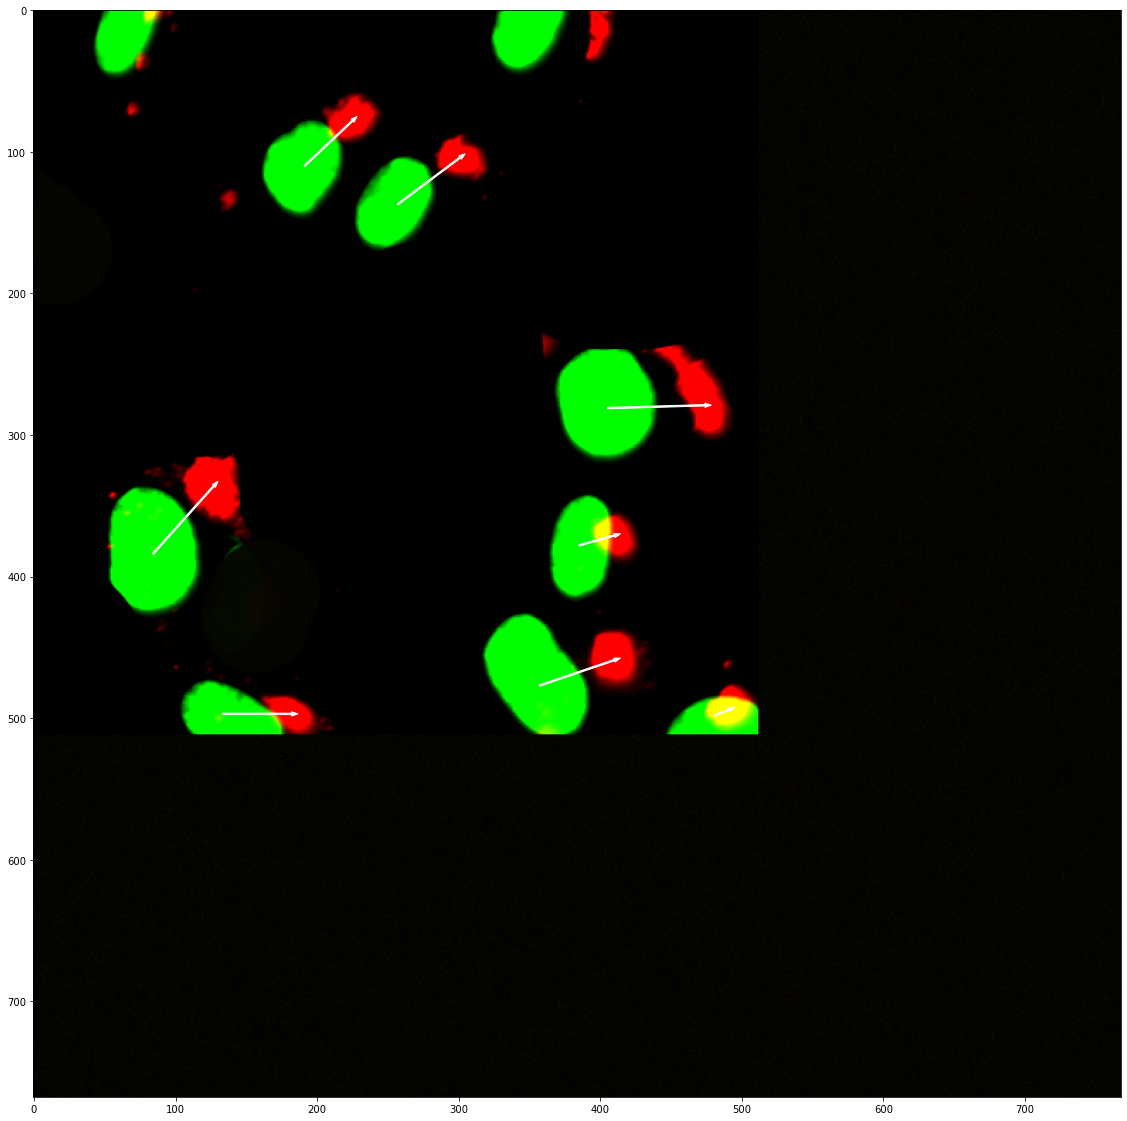

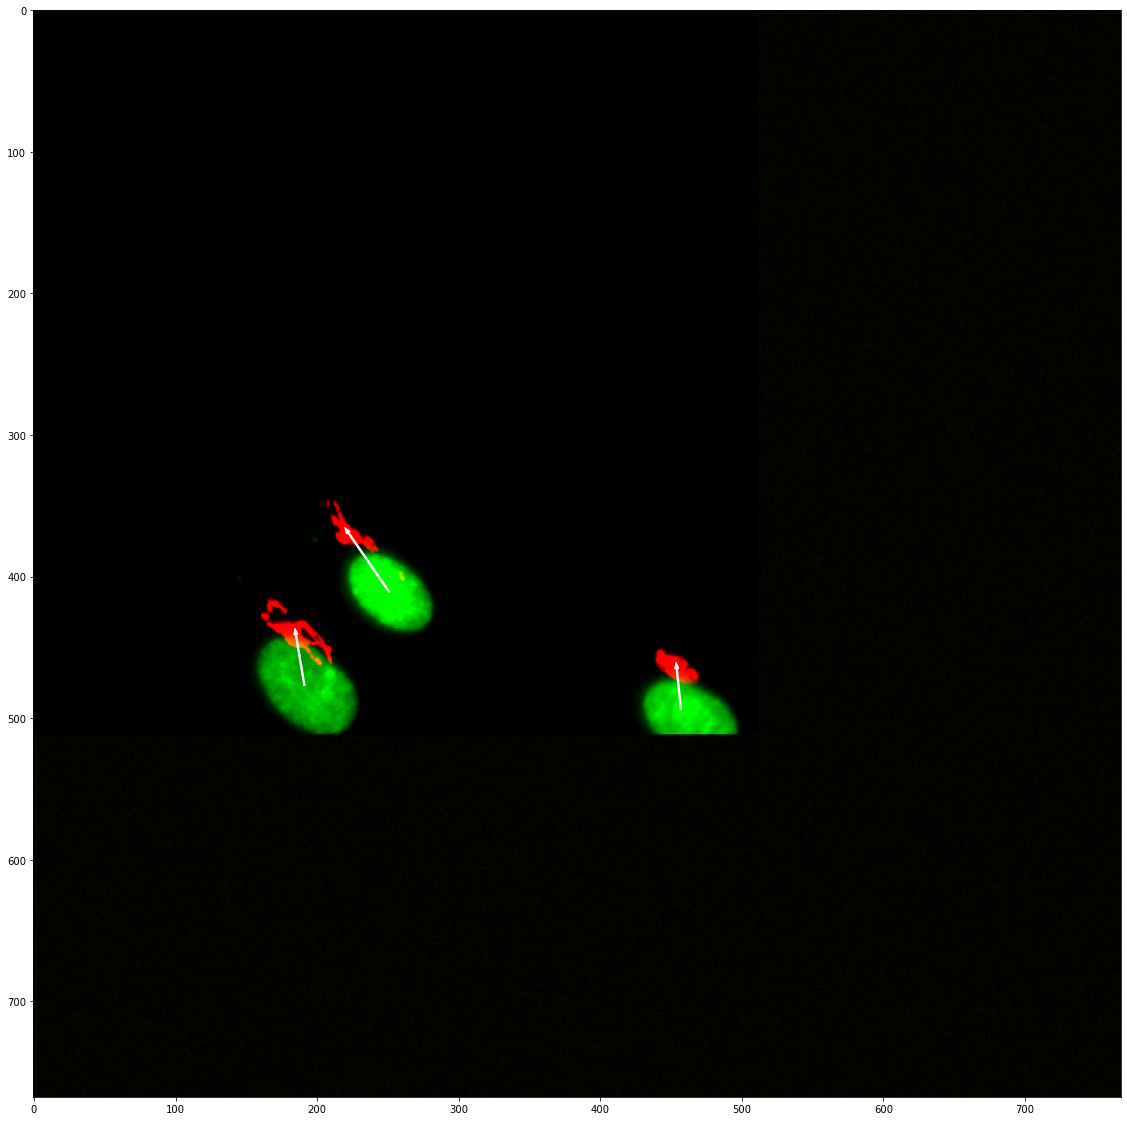

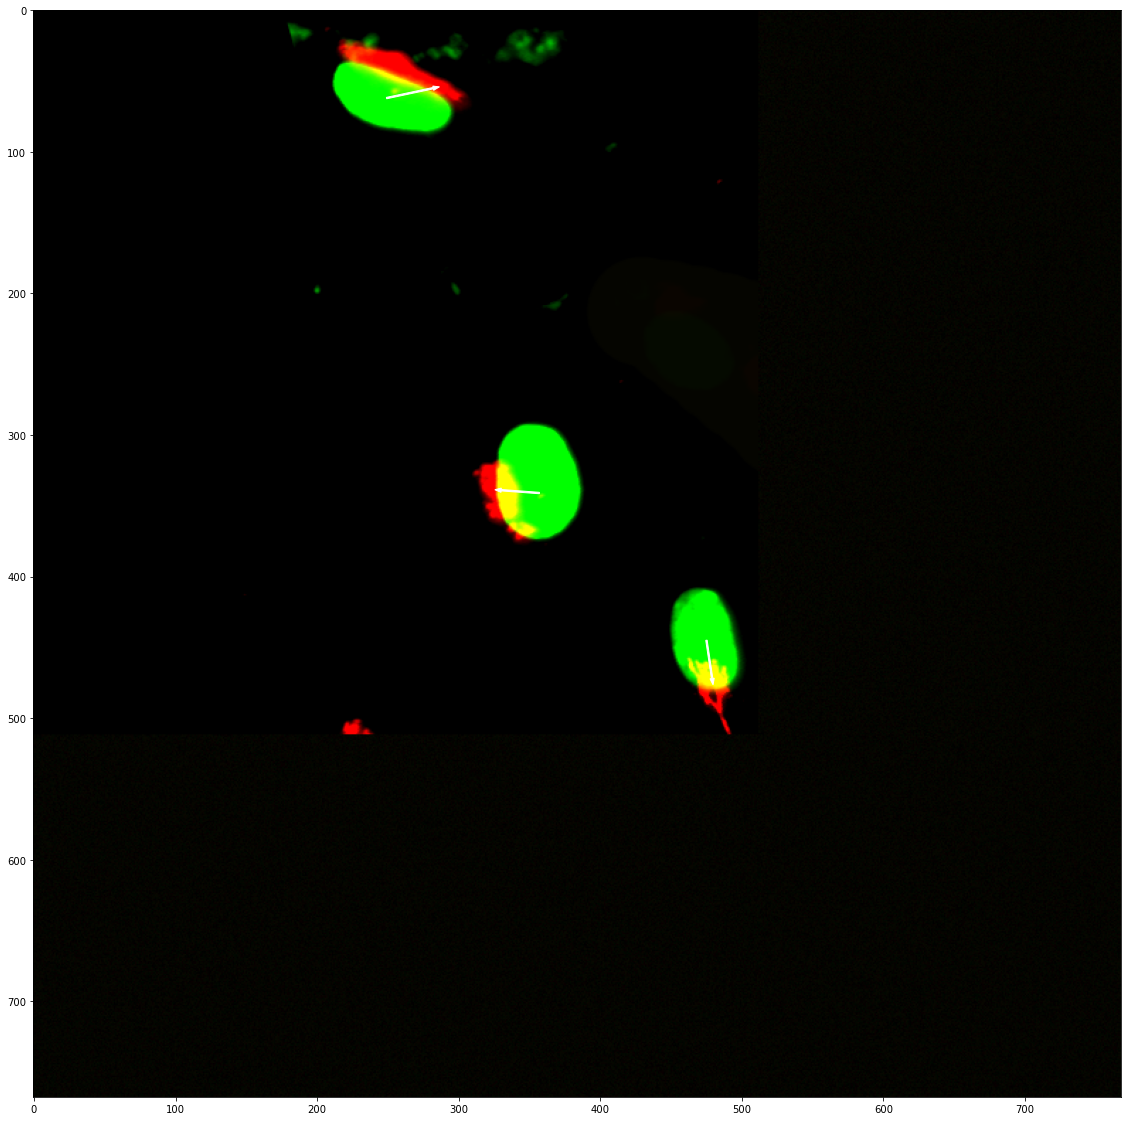

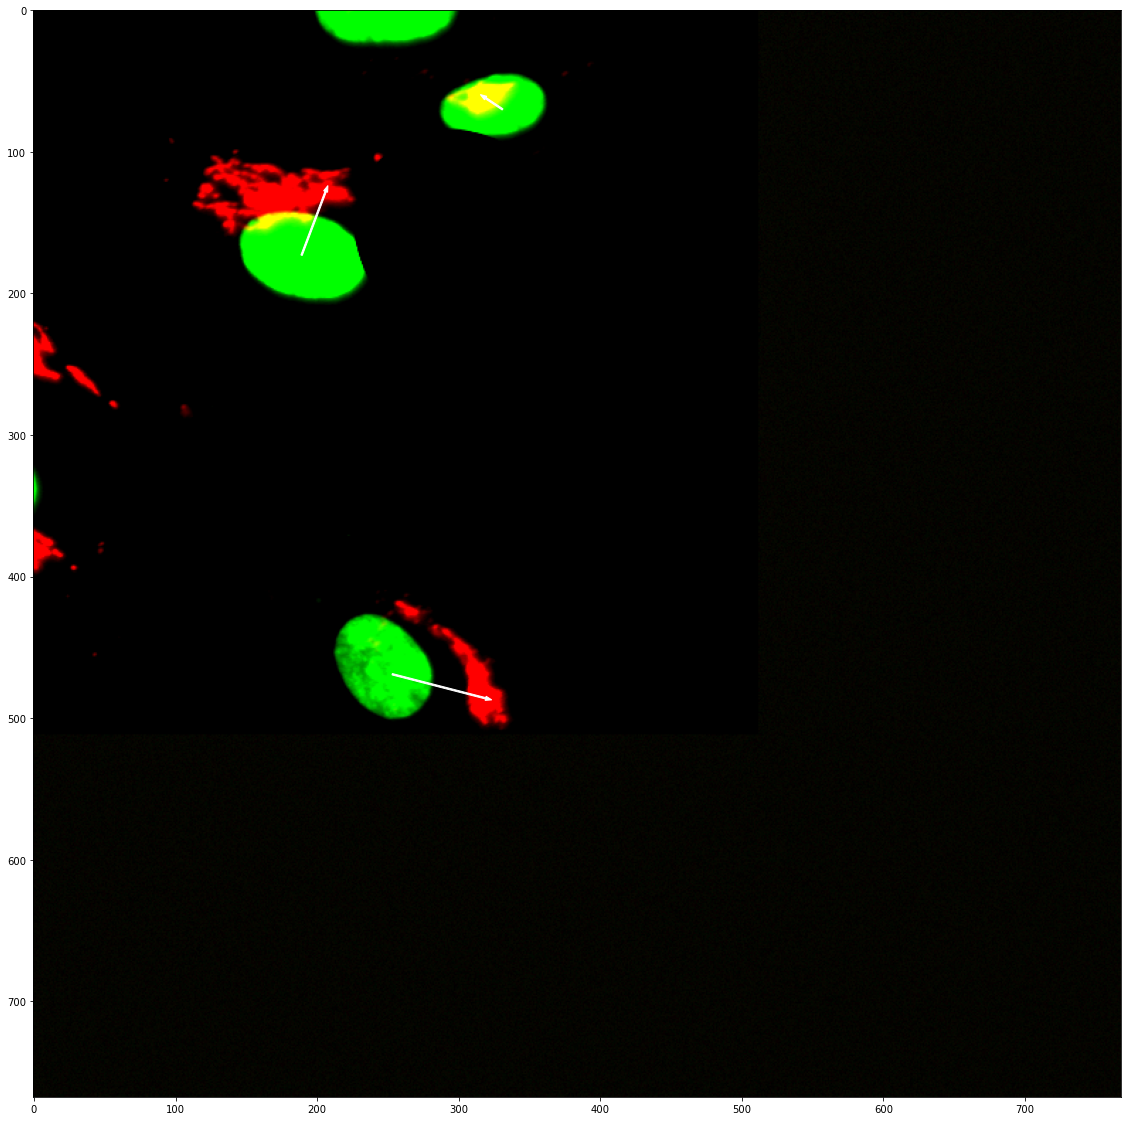

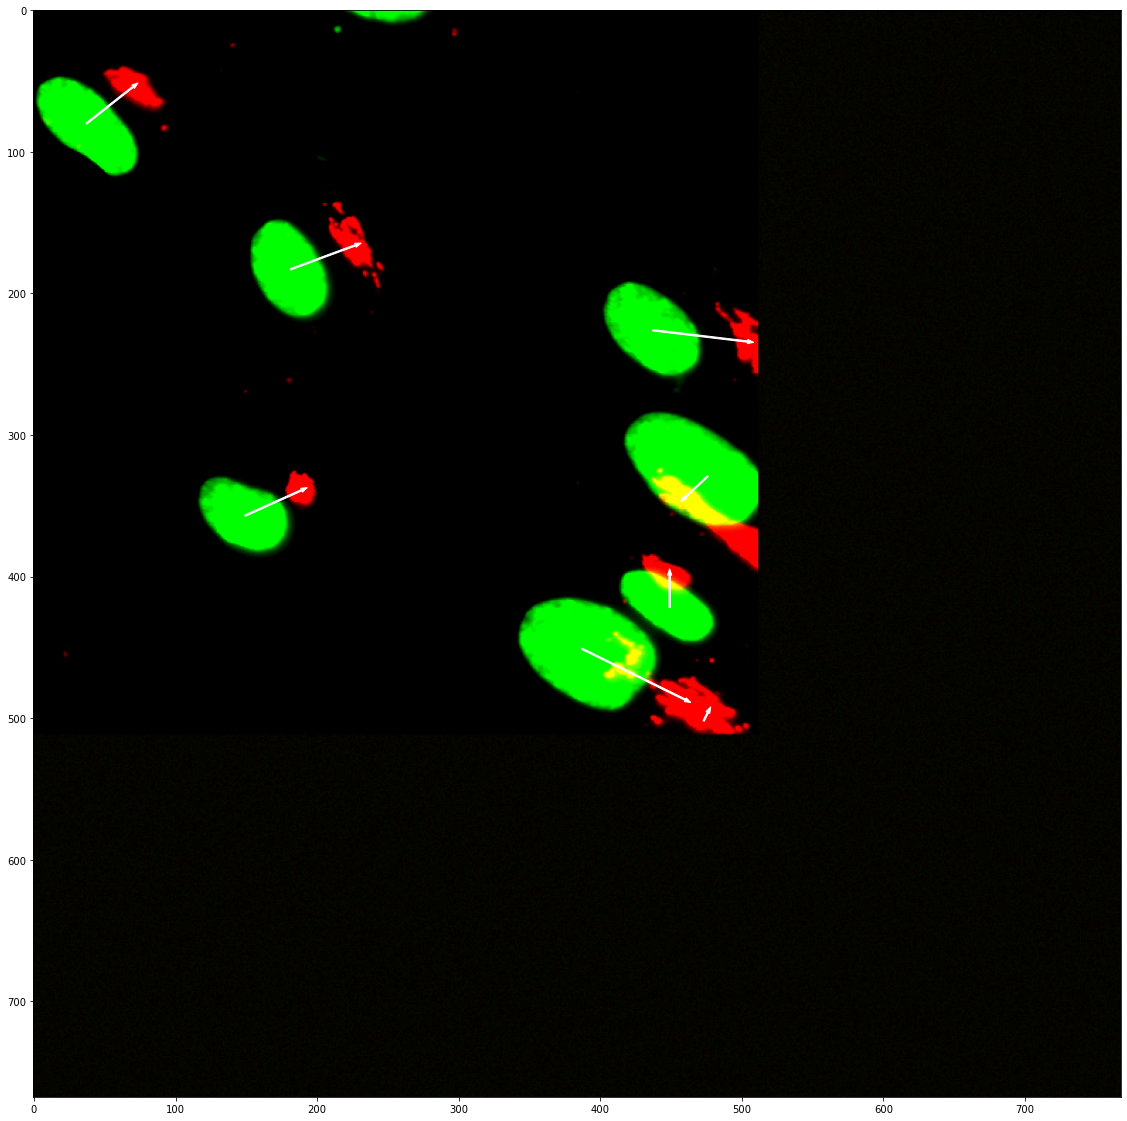

In [7]:
from utils.prediction import *

images_dir = r'/home/jovyan/discotreino/2DCellPol_Github/test/images/' # directory containing the original .tif images
                                                                          # image shape = (x,y,channels)
#parameters to test the model
golgi_dist = 4 # optimized using optimization/select_best_thresholds_golgi.py and optimization/roc_curve_golgi.py
nuclei_dist = 16 # optimized using optimization/select_best_thresholds_nuclei.py and optimization/roc_curve_nuclei.py
golgi_prob = 0.8 # optimized using optimization/select_best_thresholds_golgi.py and optimization/roc_curve_golgi.py
nuclei_prob = 0.8 # optimized using optimization/select_best_thresholds_nuclei.py and optimization/roc_curve_nuclei.py
_patch_size = 256 #original patch size
_step = 64 #x- and y-step to extract patches with some overlap along the x and y-directions
save_dir = '/home/jovyan/discotreino/2DCellPol_Github/results_test' #directory where the results will be saved
x_spacing = 0.353 #resolution across x in μm
y_spacing = 0.353 #resolution across y in μm

prediction(model_path, images_dir, golgi_dist, nuclei_dist, golgi_prob, nuclei_prob, _patch_size, _step, save_dir, x_spacing, y_spacing)

## Evaluation

In [8]:
from utils.evaluation import *

pred_dir = '/home/jovyan/discotreino/2DCellPol_Github/results_test' #directory containing the predicted nucleus and golgi centroids
gt_dir = r'/home/jovyan/discotreino/2DCellPol_Github/test/gt' #directory with the ground truth vectors
img_dir = r'/home/jovyan/discotreino/2DCellPol_Github/test/images' #directory with images
save_dir = r'/home/jovyan/discotreino/2DCellPol_Github/eval' #save the pandas df with metrics and images with tp, fp and fn vectors

evaluate(img_dir, gt_dir, pred_dir, save_dir, x_spacing, y_spacing)

Reading the csv file with the ground truth vectors
Evaluation
Drawing TP, FP and FN vectors
Reading the csv file with the ground truth vectors
Evaluation
Drawing TP, FP and FN vectors
Reading the csv file with the ground truth vectors
Evaluation
Drawing TP, FP and FN vectors
Reading the csv file with the ground truth vectors
Evaluation
Drawing TP, FP and FN vectors
Reading the csv file with the ground truth vectors
Evaluation
Drawing TP, FP and FN vectors


## Polar Histogram

In [9]:
prediction_dir = r'/home/jovyan/discotreino/2DCellPol_Github/results_test' #prediction folder defined in predict_main.py
images_dir = r'/home/jovyan/discotreino/2DCellPol_Github/test/images' # directory containing the original  .tif images, image shape = (x,y,z,channels)
dimx = 0.353 #resolution across the x direction in µm
dimy = 0.353 #resolution across the y direction in µm

##### Run the following cell to visualize the polar histogram

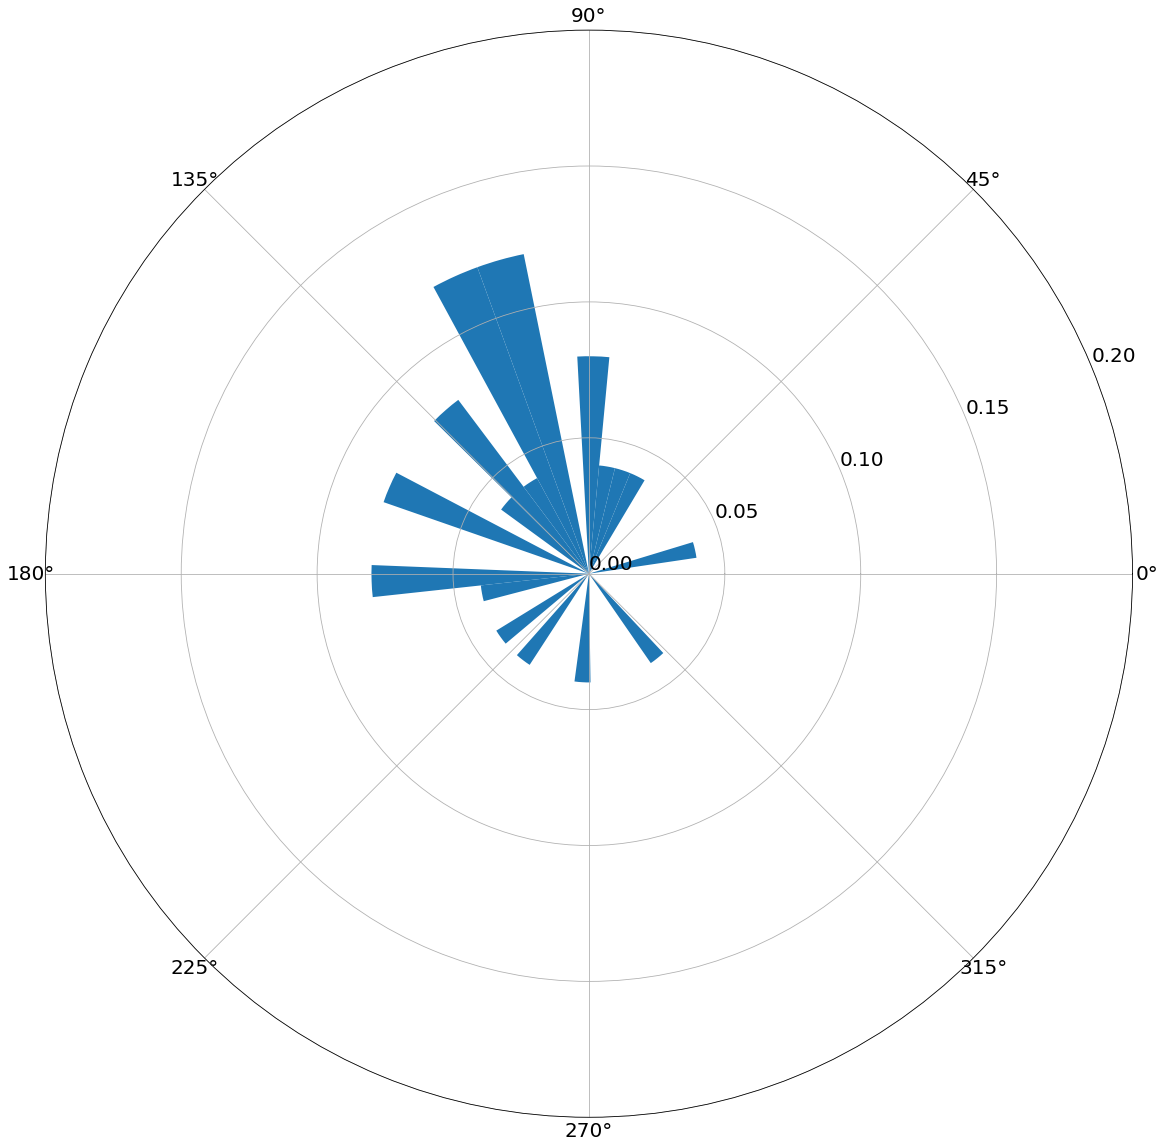

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt

image_names = [f for f in os.listdir(images_dir) if f.endswith('.tif')] ## image names

vectors = []
def distance_(p1,p2):
    dist_ = np.sqrt(((p1[0] - p2[0])**2) + ((p1[1] - p2[1])**2))
    return dist_

for iname in image_names:
    nuclei_centroids = np.load(os.path.join(prediction_dir, iname.replace('.tif','_nuclei_centroids_nms.npy'))) 
    golgi_centroids = np.load(os.path.join(prediction_dir, iname.replace('.tif','_golgi_centroids_nms.npy')))
    for N, G in zip(nuclei_centroids, golgi_centroids):
        XN = int(N[0])*dimx
        YN = int(N[1])*dimy
        XG = int(G[0])*dimx
        YG = int(G[1])*dimy
        vectors.append((XG-XN, YG-YN))
        
vectors = np.asarray(vectors)


angles = np.arctan2(vectors[:, 1], vectors[:, 0])  # y, x components


# Normalize to range [0, 2*pi]
angles = np.mod(angles, 2*np.pi)  
# Set the number of angular bins
num_bins = 36
# Create the histogram for azimuth angles and normalize to probabilities
counts, bin_edges = np.histogram(angles, bins=num_bins)
# Normalize to probabilities
counts_normalized = counts / np.sum(counts)  

# Create polar plot with normalized counts
plt.figure()
ax = plt.subplot(111, polar=True)
bars = ax.bar((bin_edges[:-1] + bin_edges[1:]) / 2, counts_normalized, width=np.diff(bin_edges), align='center')
ax.set_ylim(0, max(counts_normalized)+0.05)
radial_ticks = np.arange(0, max(counts_normalized)+0.1, 0.05)  # Adjust step as needed
ax.set_yticks(radial_ticks)
# Increase font size of radial ticks
ax.tick_params(axis='y', labelsize=20)  # Adjust 14 to desired font size
# Increase font size of angular ticks
ax.tick_params(axis='x', labelsize=20)  # Adjust 14 to desired font size
plt.savefig(os.path.join(prediction_dir, 'Polar Histogram XY.jpg'), dpi=100)